### Code

In [2]:
import os
import json
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
def class_distribution(df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    for idx, label_type in enumerate(['clean_label', 'noisy_label']):
        value_counts = df[label_type].value_counts().sort_index()
        bars = axs[idx].bar(value_counts.index, value_counts.values)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axs[idx].text(bar.get_x() + bar.get_width()/2, height, str(height), 
                          ha='center', va='bottom', fontsize=10, color='black')
        
        axs[idx].set_title(label_type)
        axs[idx].set_xticks(value_counts.index)
    
    plt.suptitle('Class Distribution')
    plt.show()

In [4]:
def corruption_plot(df):

    clean_df = df[df['noisy_label'] == df['clean_label']]
    corrupted_df = clean_df[clean_df['mean'].round().astype(int) != clean_df['noisy_label']]
    # Data for the plot
    categories = clean_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(clean_df[clean_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrupted_df[corrupted_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='green', label='Clean Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='red', label='Corrupted Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Clean Labels = {len(clean_df)}, Total Corrupted Labels = {len(corrupted_df)}, Corruption Ratio = {round(len(corrupted_df)/len(clean_df), 4)}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [5]:
def correction_plot(df):
    noisy_df = df[df['noisy_label'] != df['clean_label']]
    corrected_df = noisy_df[noisy_df['mean'].round().astype(int) == noisy_df['clean_label']]
    # Data for the plot
    categories = noisy_df["clean_label"].unique()  # X-axis labels
    values1 =  [len(noisy_df[noisy_df["clean_label"] == label]) for label in range(len(categories))] # First set of values
    values2 = [len(corrected_df[corrected_df["clean_label"] == label]) for label in range(len(categories))]  # Second set of values

    # Define the width of each bar
    bar_width = 0.35

    # Generate positions for the bars
    x = np.arange(len(categories))

    # Create the bar plot
    plt.bar(x - bar_width / 2, values1, width=bar_width, color='orange', label='Noisy Labels')
    plt.bar(x + bar_width / 2, values2, width=bar_width, color='blue', label='Corrected Labels')

    # Add labels, title, and legend
    plt.xlabel('Ground Truths')
    plt.ylabel('Number of Data')
    plt.title(f'Total Noisy Labels = {len(noisy_df)}, Total Corrected Labels = {len(corrected_df)}, Correction Ratio = {round(len(corrected_df)/len(noisy_df), 4)}')
    plt.xticks(ticks=x, labels=x)
    plt.legend()

    # Display the values on top of the bars
    for i, (v1, v2) in enumerate(zip(values1, values2)):
        plt.text(x[i] - bar_width / 2, v1 + 0.2, str(v1), ha='center')
        plt.text(x[i] + bar_width / 2, v2 + 0.2, str(v2), ha='center')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [6]:
def sigma_plot(df): 
    # Sigma Analysis
    sigma_clean = df[df['mean'].round() == df['clean_label']]['sigma']
    sigma_noisy = df[df['mean'].round() != df['clean_label']]['sigma']

    # Set fixed number of bins
    num_bins = 20
    min_val = min(sigma_clean.min(), sigma_noisy.min())
    max_val = max(sigma_clean.max(), sigma_noisy.max())
    bins = np.linspace(min_val, max_val, num_bins + 1)  # Bin edges
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Bin centers for labels

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    for ax, sigma_data, color, title in zip(
        axes, [sigma_clean, sigma_noisy], ['green', 'red'],
        ['Sigma Distribution (Clean Data)', 'Sigma Distribution (Noisy Data)']):

        # Create histogram using fixed bins
        counts, _, patches = ax.hist(sigma_data, bins=bins, color=color, alpha=0.8, edgecolor='black')

        ax.set_title(title)
        ax.set_xlabel('Sigma')
        ax.set_ylabel('Frequency')

        # Rotate x-axis labels (showing bin centers instead of edges)
        ax.set_xticks(bin_centers)  
        ax.set_xticklabels([f"{tick:.2f}" for tick in bin_centers], rotation=90)

        # Add value labels on top of bars
        for count, patch in zip(counts, patches):
            if count > 0:
                ax.text(patch.get_x() + patch.get_width()/2, count, int(count), 
                        ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.tight_layout()
    plt.show()


In [7]:
def display_sample_cases(df, n=3, high_sigma=True):
    sample = df.sort_values('sigma', ascending=not high_sigma).head(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i, (idx, row) in enumerate(sample.iterrows()):
        img = plt.imread(row['img_path'])
        axs[i].imshow(img)
        axs[i].set_title(f"Noisy: {row['noisy_label']}\nClean: {row['clean_label']}\nMean: {row['mean']}\nSigma: {row['sigma']:.2f}")
        axs[i].axis('off')
    plt.suptitle(f"Sample {'High' if high_sigma else 'Low'} Sigma Cases")
    plt.show()

In [8]:
def label_confusion(df):
    # 1. Confusion Matrix: Noisy vs. Corrected vs. Clean
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    copy_df = copy.deepcopy(df)
    # Discretize the `mean` column to match `clean_label`
    copy_df['mean_discretized'] = copy_df['mean'].round().astype(int)

    # Confusion matrices
    confusion_noisy_clean = confusion_matrix(copy_df['noisy_label'],
                                            copy_df['clean_label'])
    # Compute confusion matrix for corrected means vs. clean labels
    confusion_corrected_clean = confusion_matrix(
        copy_df['mean_discretized'], 
        copy_df['clean_label']
    )

    # Plot confusion matrices
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay(confusion_noisy_clean).plot(ax=ax[0], cmap='Blues')
    ax[0].set_title('Noisy Label vs. Clean Label')
    ConfusionMatrixDisplay(confusion_corrected_clean).plot(ax=ax[1], cmap='Blues')
    ax[1].set_title('Corrected Mean vs. Clean Label')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_mean_sigma_hist_split(df):
    # Group the DataFrame by 'noisy_label'
    grouped = df.groupby('noisy_label')
    
    # Determine the number of unique noisy_labels
    num_labels = len(grouped)
    
    # Create a figure with subplots: one row per noisy_label, four columns
    fig, axes = plt.subplots(num_labels, 4, figsize=(20, 5 * num_labels))
    
    # If there's only one noisy_label, axes will be 1D, so we reshape it for consistency
    if num_labels == 1:
        axes = axes.reshape(1, -1)
    
    # Iterate over each noisy_label group
    for i, (label, group) in enumerate(grouped):
        # Calculate the mean of 'mean_hist' for each row and round it
        group['mean_rounded'] = group['mean_hist'].apply(lambda x: round(np.mean(x)))
        
        # Split the group into two subsets:
        # 1. clean_label == round(mean)
        # 2. clean_label != round(mean)
        equal_mask = group['clean_label'] == group['mean_rounded']
        equal_group = group[equal_mask]
        not_equal_group = group[~equal_mask]
        
        # Extract mean_hist and sigma_hist for both subsets
        mean_hist_equal = np.array(equal_group['mean_hist'].tolist())
        sigma_hist_equal = np.array(equal_group['sigma_hist'].tolist())
        
        mean_hist_not_equal = np.array(not_equal_group['mean_hist'].tolist())
        sigma_hist_not_equal = np.array(not_equal_group['sigma_hist'].tolist())
        
        # Calculate mean and std for mean_hist and sigma_hist for both subsets
        mean_mean_hist_equal = np.mean(mean_hist_equal, axis=0)
        std_mean_hist_equal = np.std(mean_hist_equal, axis=0)
        
        mean_sigma_hist_equal = np.mean(sigma_hist_equal, axis=0)
        std_sigma_hist_equal = np.std(sigma_hist_equal, axis=0)
        
        mean_mean_hist_not_equal = np.mean(mean_hist_not_equal, axis=0)
        std_mean_hist_not_equal = np.std(mean_hist_not_equal, axis=0)
        
        mean_sigma_hist_not_equal = np.mean(sigma_hist_not_equal, axis=0)
        std_sigma_hist_not_equal = np.std(sigma_hist_not_equal, axis=0)
        
        # Generate positions for the x-axis
        positions = np.arange(len(mean_mean_hist_equal))
        
        # Plot for clean_label == round(mean) (left two subplots)
        ax = axes[i, 0]
        ax.plot(positions, mean_mean_hist_equal, label='Mean', color='blue', linewidth=2)
        ax.fill_between(positions, mean_mean_hist_equal - std_mean_hist_equal, mean_mean_hist_equal + std_mean_hist_equal, 
                        color='blue', alpha=0.3, label='Std Dev')
        ax.set_title(f'Mean Hist (clean_label == round(mean), noisy_label = {label})')
        ax.set_xlabel('Position')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        ax = axes[i, 1]
        ax.plot(positions, mean_sigma_hist_equal, label='Mean', color='green', linewidth=2)
        ax.fill_between(positions, mean_sigma_hist_equal - std_sigma_hist_equal, mean_sigma_hist_equal + std_sigma_hist_equal, 
                        color='green', alpha=0.3, label='Std Dev')
        ax.set_title(f'Sigma Hist (clean_label == round(mean), noisy_label = {label})')
        ax.set_xlabel('Position')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Plot for clean_label != round(mean) (right two subplots)
        ax = axes[i, 2]
        ax.plot(positions, mean_mean_hist_not_equal, label='Mean', color='red', linewidth=2)
        ax.fill_between(positions, mean_mean_hist_not_equal - std_mean_hist_not_equal, mean_mean_hist_not_equal + std_mean_hist_not_equal, 
                        color='red', alpha=0.3, label='Std Dev')
        ax.set_title(f'Mean Hist (clean_label != round(mean), noisy_label = {label})')
        ax.set_xlabel('Position')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        ax = axes[i, 3]
        ax.plot(positions, mean_sigma_hist_not_equal, label='Mean', color='orange', linewidth=2)
        ax.fill_between(positions, mean_sigma_hist_not_equal - std_sigma_hist_not_equal, mean_sigma_hist_not_equal + std_sigma_hist_not_equal, 
                        color='orange', alpha=0.3, label='Std Dev')
        ax.set_title(f'Sigma Hist (clean_label != round(mean), noisy_label = {label})')
        ax.set_xlabel('Position')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame with columns 'noisy_label', 'clean_label', 'mean_hist', and 'sigma_hist'
# plot_mean_sigma_hist_split(df)

In [10]:
def get_history_dicts(root):
    mean_history_paths = [os.path.join(root, f"split{split}", 'mean_history.json') for split in range(5)]
    sigma_history_paths = [os.path.join(root, f"split{split}", 'sigma_history.json') for split in range(5)]
    mean_history = dict()
    sigma_history = dict()
    for mean_history_path, sigma_history_path in zip(mean_history_paths, sigma_history_paths):
        with open(mean_history_path, 'r') as f:
            mean_history.update(json.load(f))
        with open(sigma_history_path, 'r') as f:
            sigma_history.update(json.load(f))
    
    mean_history = {int(k): v for k, v in mean_history.items()}
    sigma_history = {int(k): v for k, v in sigma_history.items()}
    
    return mean_history, sigma_history

In [11]:
def get_df(noisy_root, clean_root, result_root=None):
    # List of CSV files
    files = [os.path.join(noisy_root, f'data_split{i}.csv') for i in range(5)]

    # List to store filtered data
    filtered_data = []

    # Read files and filter data
    ids = list()
    for file in files:
        df = pd.read_csv(file, header=None)  # No header in the files
        for _, row in df.iterrows():
            id = row[0]
            folder = row[2]  # Third column is folder
            if id in ids or folder == 2:
                continue
            else:
                # if folder in [0, 1]:  # Only include rows where folder is 0 or 1
                    # Drop the folder column (index 2) and keep the rest
                filtered_row = row.drop(2).tolist()
                filtered_data.append(filtered_row)
                ids.append(id)

    # Create a new DataFrame from the filtered data
    # Define column names (assuming the original CSV files have no headers)
    columns = ["id", "img_path", "noisy_label", "mean", "sigma"]  # Adjust column names as needed
    df = pd.DataFrame(filtered_data, columns=columns)

    clean_file = os.path.join(clean_root, f"data_split0.csv")
    clean_df = pd.read_csv(clean_file, header=None)
    df['clean_label'] = clean_df[3]
    
    if result_root:
        mean_hist, sigma_hist = get_history_dicts(result_root)
        df['mean_hist'] = df['id'].map(mean_hist)
        df['sigma_hist'] = df['id'].map(sigma_hist)
        
    return df

### DRUnder_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3

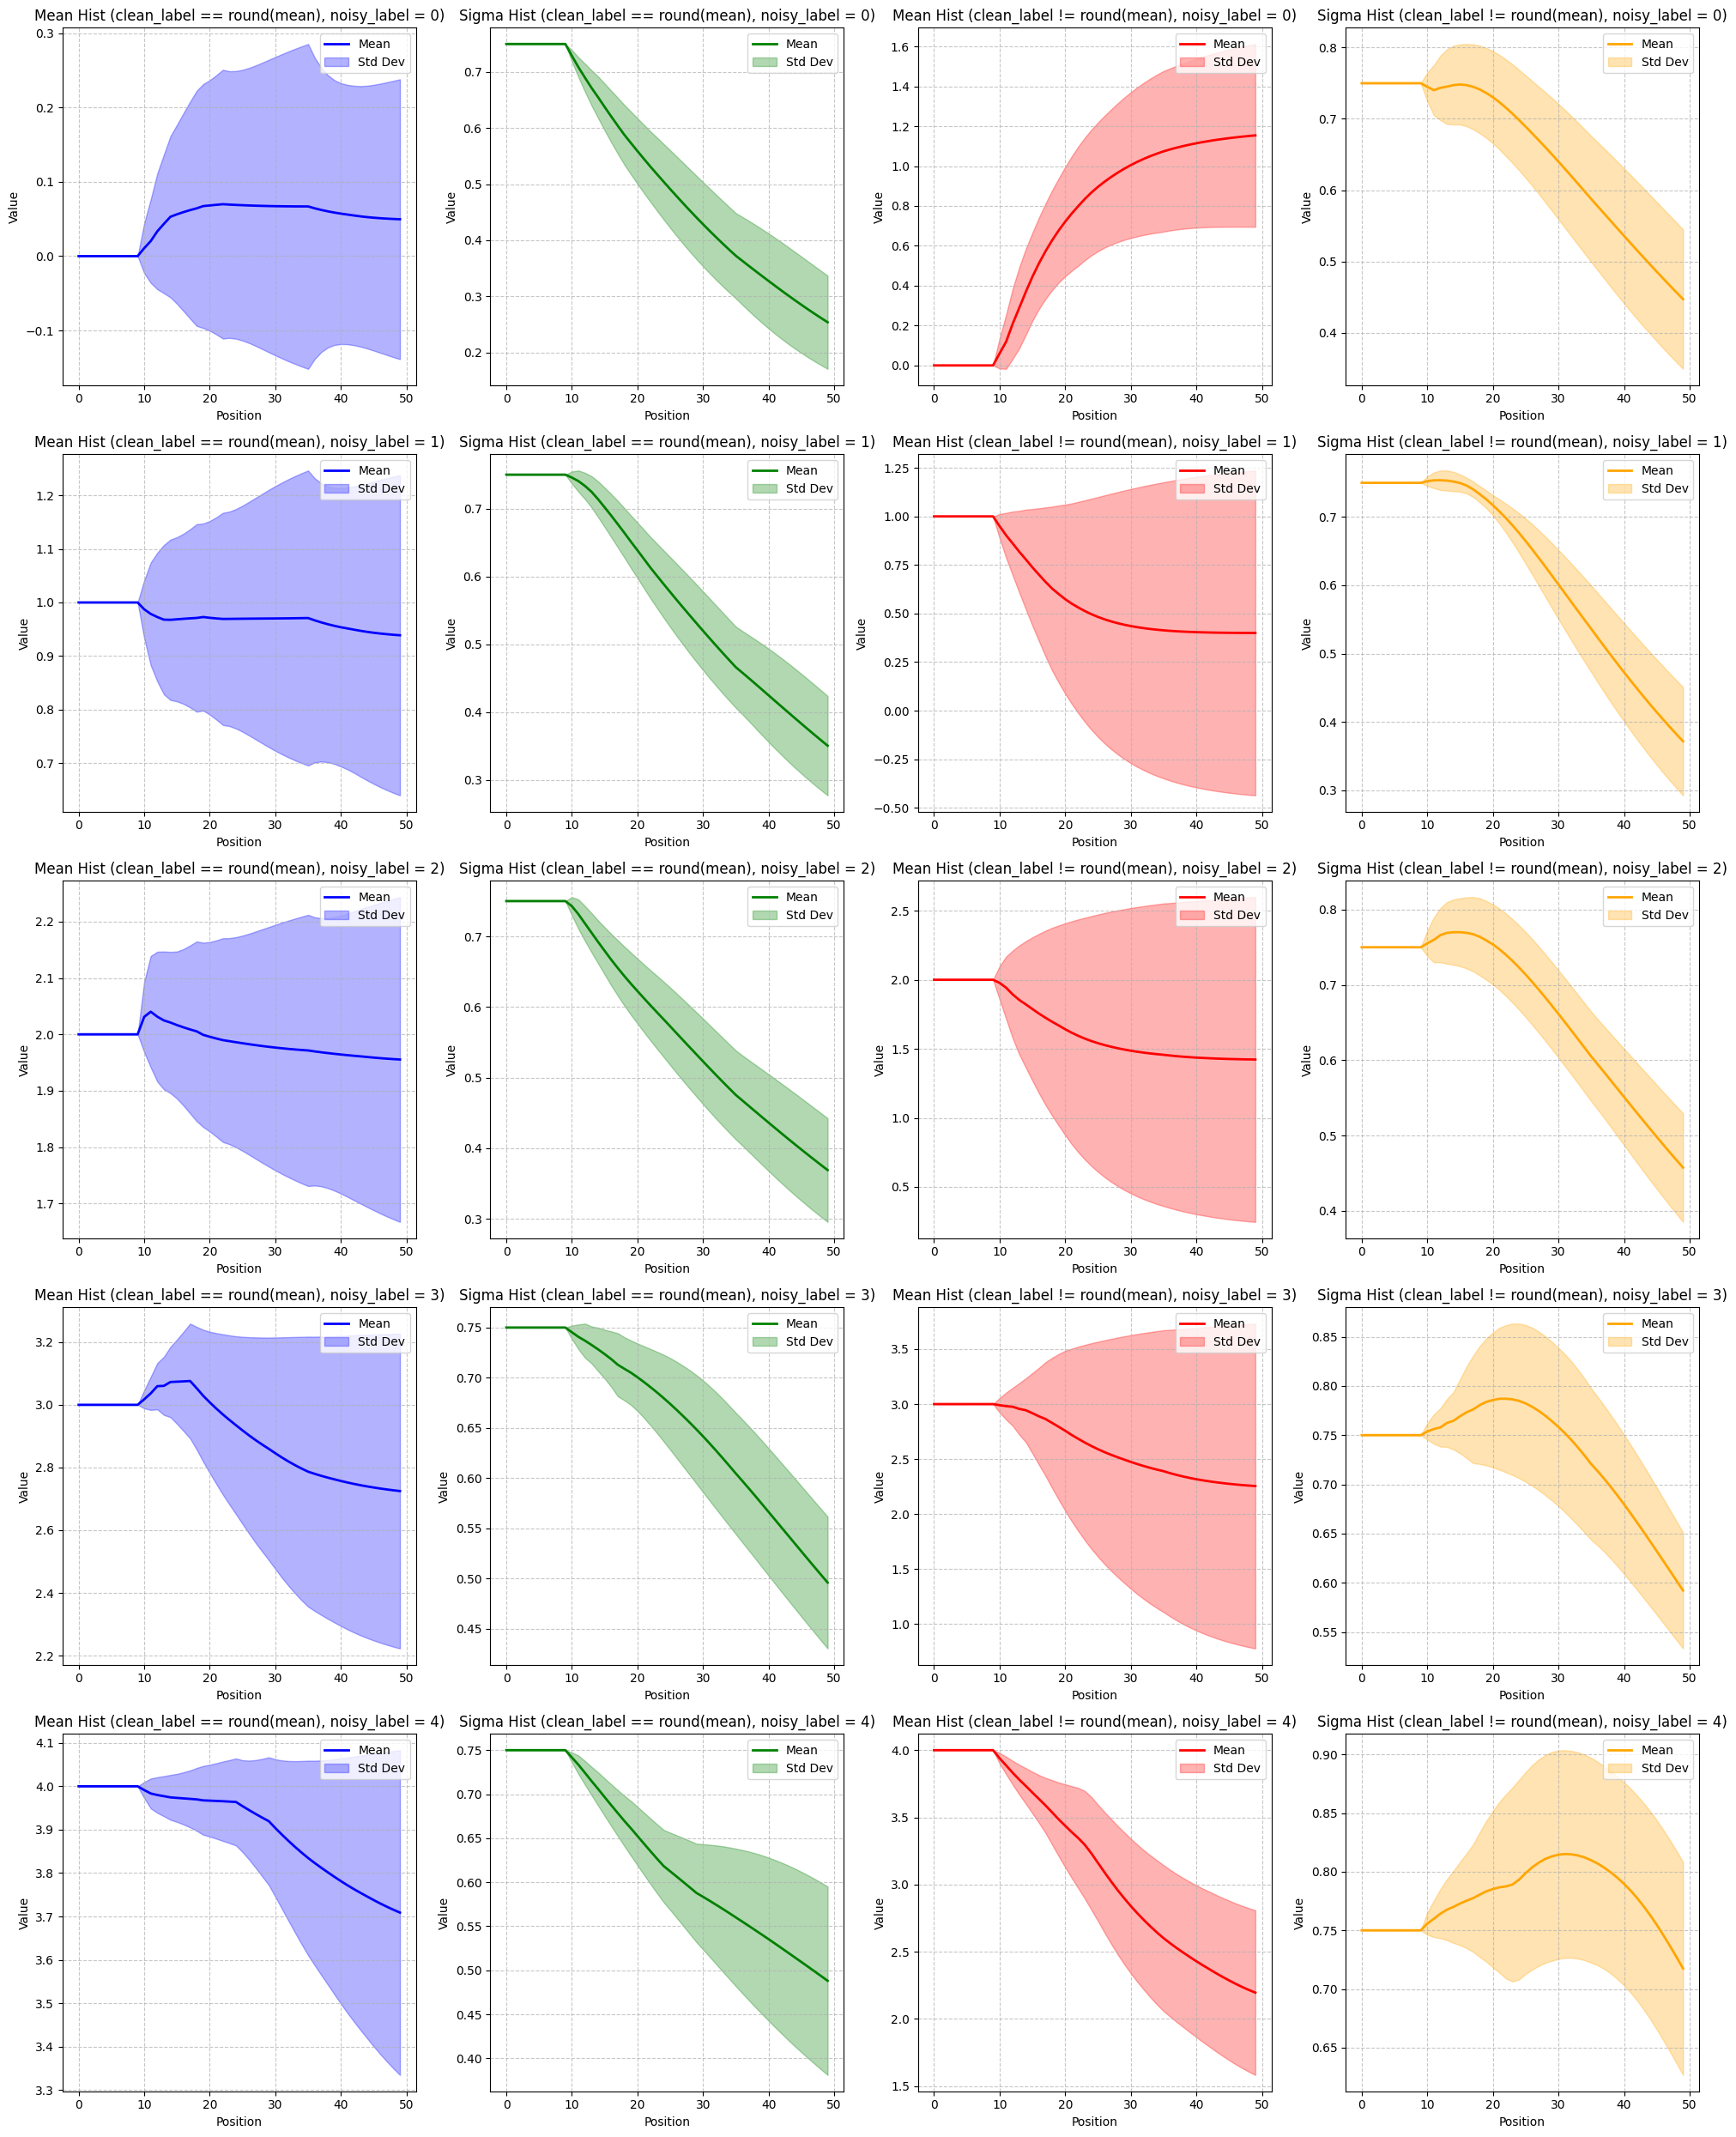

In [12]:
df = get_df(noisy_root='../facebase/data/DRUnder_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3',
            clean_root='../facebase/data/DRUnder_256x256_resnet50_imagenet_dldl_v2_clean',
            result_root='../facebase/results/DRUnder_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3')

plot_mean_sigma_hist_split(df)